In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
import torch
from torch.nn import MSELoss

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

c:\Users\Propietario\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Voy a importar las señales igual que lo hice con el modelo TiDE

In [53]:
# Obtener 50 señales para analizar y predecir

muestreo_corto = 100 # Cada cuantos tiempos tomamos un timepo para entrenar la NODE
muestreo_largo = 1
t_short = np.linspace(0, 0.1, 1000)[0:1000:muestreo_corto]
t_long = np.linspace(0.1, 1, 100)[0:100:muestreo_largo]

time_variable = np.concatenate((t_short,t_long))
file_path = "C:/Users/Propietario/Desktop/ib/Tesis_V1/Proyecto_Tesis/1-GeneracionDeDatos/Datos_Final/datos_PCA/dataSignals.csv"
pd_data = pd.read_csv(file_path)

In [54]:
pd_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x55091,x55092,x55093,x55094,x55095,x55096,x55097,x55098,x55099,x55100
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999997,0.999997,0.999997,0.999997,0.999997,0.999997,0.999997,0.999997,0.999997,0.999997,...,0.999995,0.999995,0.999995,0.999995,0.999995,0.999995,0.999995,0.999995,0.999995,0.999996
2,0.999979,0.999979,0.999979,0.999979,0.999979,0.999979,0.999979,0.999979,0.999979,0.999979,...,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964
3,0.999945,0.999945,0.999945,0.999945,0.999945,0.999945,0.999945,0.999945,0.999945,0.999945,...,0.999880,0.999880,0.999880,0.999880,0.999881,0.999881,0.999881,0.999881,0.999881,0.999881
4,0.999897,0.999897,0.999897,0.999897,0.999897,0.999897,0.999897,0.999897,0.999897,0.999896,...,0.999718,0.999718,0.999719,0.999719,0.999719,0.999719,0.999720,0.999720,0.999720,0.999721


In [55]:
column_names = [f'x{i}' for i in range(1,55101)]
datos = pd_data[column_names].to_numpy().transpose()

In [56]:
print("Size of data:", datos.shape)
# Usar 50 señales
datos_utilizados = datos[99:10000:200,:]
# Usar 1 señal
# datos_utilizados = datos[50,:]
print("Size of data used:", datos_utilizados.shape)

# Cambiamos el tamaño de los datos para hacerlos mas chicos y poder trabajar con ellos

datos_short = datos_utilizados[:,0:1001:muestreo_corto]
datos_long = datos_utilizados[:,1001::muestreo_largo]

datos_utilizados = np.concatenate((datos_short,datos_long), axis = 1).transpose()
print("Actual size of data used:", datos_utilizados.shape)

Size of data: (55100, 1100)
Size of data used: (50, 1100)
Actual size of data used: (110, 50)


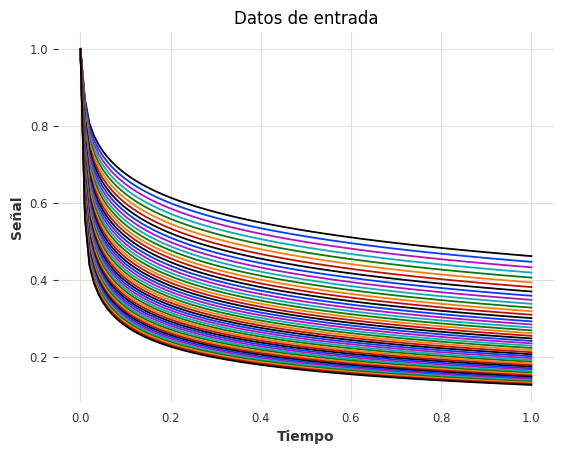

In [57]:
# Veamos como se ven los datos
for i in range(50):
    plt.plot(time_variable, datos_utilizados[:,i])
plt.title('Datos de entrada')
plt.xlabel('Tiempo')
plt.ylabel('Señal')
plt.show()

In [58]:
series = TimeSeries.from_values(datos_utilizados)
times = np.reshape(time_variable, (len(datos_utilizados),1))

In [59]:
train, test = series[:-60], series[-60:]
times_train, times_test = times[:-60], times[-60:]

In [60]:
print("Longitud de datos entrenamiento:",len(train))
print("Longitud de datos prueba:",len(test))

Longitud de datos entrenamiento: 50
Longitud de datos prueba: 60


In [61]:
input_chunk_length = 40
forecast_horizon = 10

In [62]:
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=10,
    n_epochs=2000,
    add_relative_index=True,
    add_encoders=None,
    likelihood=None,  #QuantileRegression is set per default
    loss_fn=torch.nn.MSELoss(),
    random_state=42,
)

In [63]:
my_model.fit(train)

Epoch 1999: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s, train_loss=1.65e-5]


TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=MSELoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=40, output_chunk_length=10, batch_size=10, n_epochs=2000, add_encoders=None, random_state=42)

In [64]:
pred_series = my_model.predict(n=60)

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


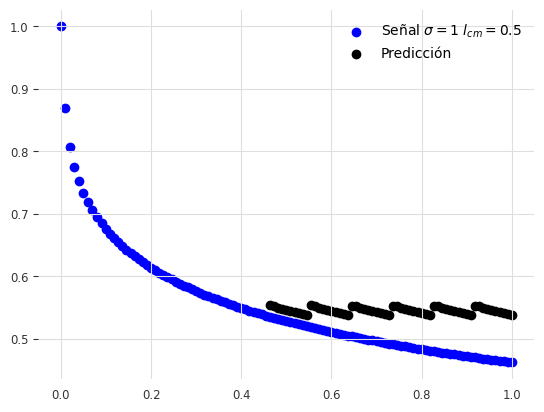

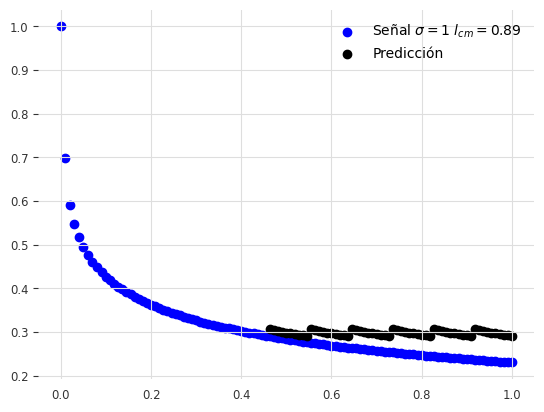

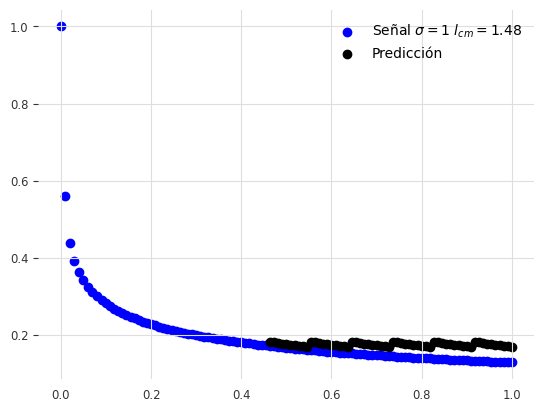

In [81]:
plt.scatter(times_train, train.values()[:,0], label=r'Señal $\sigma = 1$ $l_{cm} = 0.5$', color = 'blue')
plt.scatter(times_test, test.values()[:,0], label=None, color = 'blue')
plt.scatter(times_test, pred_series.values()[:,0], label='Predicción')
plt.legend()
plt.savefig("TFT_signal1.png")
plt.show()

plt.scatter(times_train, train.values()[:,24], label=r'Señal $\sigma = 1$ $l_{cm} = 0.89$', color = 'blue')
plt.scatter(times_test, test.values()[:,24], label=None, color = 'blue')
plt.scatter(times_test, pred_series.values()[:,24], label='Predicción')
plt.legend()
plt.savefig("TFT_signal2.png")
plt.show()

plt.scatter(times_train, train.values()[:,49], label=r'Señal $\sigma = 1$ $l_{cm} = 1.48$', color = 'blue')
plt.scatter(times_test, test.values()[:,49], label=None, color = 'blue')
plt.scatter(times_test, pred_series.values()[:,49], label='Predicción')
plt.legend()
plt.savefig("TFT_signal3.png")
plt.show()


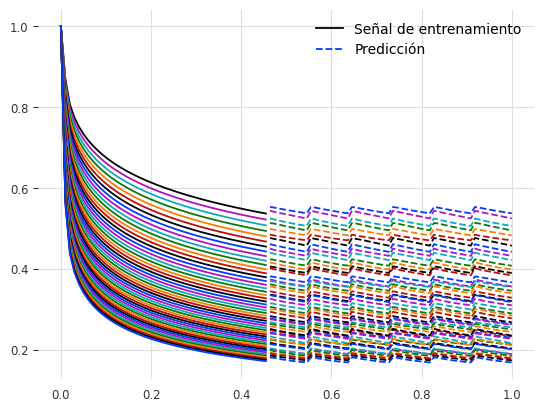

In [82]:
plt.plot(times_train, train.values()[:,0], label='Señal de entrenamiento')
plt.plot(times_test, pred_series.values()[:,0], label='Predicción', linestyle = '--')
plt.plot(times_train, train.values()[:,1:], label=None)
plt.plot(times_test, pred_series.values()[:,1:], label=None, linestyle = '--')
plt.legend()
plt.savefig("TFTSignals_Forecast.png")
plt.show()